In [1]:
import os
import sys
import time
import socket
import random
import argparse
import importlib
import scipy.misc
import statistics 
import numpy as np
import tensorflow as tf
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Append python path
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, 'utils'))
sys.path.append(os.path.join(BASE_DIR, 'models'))

# Import pointnet stuff
import pc_util
import provider

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# BASIC CONFIGURATION

In [2]:
BATCH_SIZE = 4
NUM_POINT = 1024
MODEL_DIR = 'log'
GPU_INDEX = 0
MODEL = importlib.import_module('pointnet_cls') # import network module
DUMP_DIR = 'dump'
VISUALIZATION = False
if not os.path.exists(DUMP_DIR):
    os.mkdir(DUMP_DIR)
    

HOSTNAME = socket.gethostname()
NUM_CLASSES = 40
SHAPE_NAMES = [line.rstrip() for line in \
    open(os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/shape_names.txt'))] 

# ModelNet40 official train/test split
TRAIN_FILES = provider.getDataFiles( \
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/train_files.txt'))
TEST_FILES = provider.getDataFiles(\
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/test_files.txt'))

# EVALUATE ONE EPOCH METHOD

Args:

  **sess** - tf session
  
  **ops** - parameters
  
  

Returns:

  **loss** - mean classification loss
  
  **accuracy** - instance classification accuracy
  
  **class_accuracy** - class classification accuracy
  
  **predictions** - array of the output ofthe classification module with shape: (N, 40), where N is the test clouds len
  
  **true_labels** - true labels of test clouds with the lenght of N
  

In [3]:
def eval_one_epoch(sess, ops, num_votes=1, topk=1, verbose=False):
    error_cnt = 0
    is_training = False
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    fout = open(os.path.join(DUMP_DIR, 'pred_label.txt'), 'w')
    pred_vals = []
    true_vals = []
    for fn in range(len(TEST_FILES)):
        if verbose:
            print('----'+str(fn)+'----')
        current_data, current_label = provider.loadDataFile(TEST_FILES[fn])
        current_data = current_data[:,0:NUM_POINT,:]
        current_label = np.squeeze(current_label)
        if verbose:
            print(current_data.shape)
        
        file_size = current_data.shape[0]
        num_batches = file_size // BATCH_SIZE
        if verbose:
            print(file_size)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE
            cur_batch_size = end_idx - start_idx
            
            # Aggregating BEG
            batch_loss_sum = 0 # sum of losses for the batch
            batch_pred_sum = np.zeros((cur_batch_size, NUM_CLASSES)) # score for classes
            batch_pred_classes = np.zeros((cur_batch_size, NUM_CLASSES)) # 0/1 for classes
            for vote_idx in range(num_votes):
                rotated_data = provider.rotate_point_cloud_by_angle(current_data[start_idx:end_idx, :, :],
                                                  vote_idx/float(num_votes) * np.pi * 2)
                feed_dict = {ops['pointclouds_pl']: rotated_data,
                             ops['labels_pl']: current_label[start_idx:end_idx],
                             ops['is_training_pl']: is_training}
                loss_val, pred_val = sess.run([ops['loss'], ops['pred']],
                                          feed_dict=feed_dict)
                batch_pred_sum += pred_val
                batch_pred_val = np.argmax(pred_val, 1)
                for el_idx in range(cur_batch_size):
                    batch_pred_classes[el_idx, batch_pred_val[el_idx]] += 1
                batch_loss_sum += (loss_val * cur_batch_size / float(num_votes))
                
            # DANIEL
            pred_vals.append(batch_pred_sum.copy())
            true_vals.append(current_label[start_idx:end_idx].copy())
        
            # pred_val_topk = np.argsort(batch_pred_sum, axis=-1)[:,-1*np.array(range(topk))-1]
            # pred_val = np.argmax(batch_pred_classes, 1)
            pred_val = np.argmax(batch_pred_sum, 1)
            # Aggregating END
            
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            # correct = np.sum(pred_val_topk[:,0:topk] == label_val)
            total_correct += correct
            total_seen += cur_batch_size
            loss_sum += batch_loss_sum

            for i in range(start_idx, end_idx):
                l = current_label[i]
                total_seen_class[l] += 1
                total_correct_class[l] += (pred_val[i-start_idx] == l)
                fout.write('%d, %d\n' % (pred_val[i-start_idx], l))
                
                if pred_val[i-start_idx] != l and VISUALIZATION: # ERROR CASE, DUMP!
                    img_filename = '%d_label_%s_pred_%s.jpg' % (error_cnt, SHAPE_NAMES[l],
                                                           SHAPE_NAMES[pred_val[i-start_idx]])
                    img_filename = os.path.join(DUMP_DIR, img_filename)
                    output_img = pc_util.point_cloud_three_views(np.squeeze(current_data[i, :, :]))
                    scipy.misc.imsave(img_filename, output_img)
                    error_cnt += 1
    
    eval_mean_loss = (loss_sum / float(total_seen))
    eval_instance_acc = (total_correct / float(total_seen))
    eval_class_acc = (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float)))
    
    pred_vals = np.concatenate(pred_vals)
    true_vals = np.concatenate(true_vals)
    
    if verbose:
        print('eval mean loss: %f' % eval_mean_loss)
        print('eval accuracy: %f' % eval_instance_acc)
        print('eval avg class acc: %f' % eval_class_acc)
    
    class_accuracies = np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float)
    if verbose:
        for i, name in enumerate(SHAPE_NAMES):
            print('%10s:\t%0.3f' % (name, class_accuracies[i]))
            
    return eval_mean_loss, eval_instance_acc, eval_class_acc, pred_vals, true_vals

# EVALUATE METHOD

Args:

  **model_num** - number of the pointnet model (i.e.: 3 to evaluate model_3.ckpt model)
  
  **num_votes** - how many votes (one vote is one pc rotation & permutation) should be used to eval the model

Returns:

  ** same as *eval_one_epoch* **

In [4]:
def evaluate(model_num, num_votes, verbose=False):
    is_training = False
    
    # Reset
    tf.reset_default_graph()
     
    with tf.device('/GPU:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())

        # simple model
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
        loss = MODEL.get_loss(pred, labels_pl, end_points)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        
    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = True
    sess = tf.Session(config=config)

    # Get model path
    model_path = os.path.join(MODEL_DIR, 'model_' + str(model_num) + '.ckpt')
    
    # Restore variables from disk.
    saver.restore(sess, model_path)
    if verbose:
        print("Model restored.")

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss}

    return eval_one_epoch(sess, ops, num_votes, verbose)

# # # # # # # # # # # # # # # # # # # # # # # # # # #
# NUM_VOTES TEST
# # # # # # # # # # # # # # # # # # # # # # # # # # #

In [7]:
NUM_VOTES = 15
RANGE_MODELS = range(1, 11)
num_votes_accs = {i: [] for i in RANGE_MODELS}
for i in num_votes_accs:
    for x in range(1, NUM_VOTES+1):
        _, acc, _, _, _ = evaluate(model_num=i, num_votes=x, verbose=False)
        num_votes_accs[i].append(acc)
        print ('i=', i, 'x=', x, 'acc = ', acc)

INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_1.ckpt
('i=', 1, 'x=', 1, 'acc = ', 0.8869529983792545)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_1.ckpt
('i=', 1, 'x=', 2, 'acc = ', 0.8881685575364667)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_1.ckpt
('i=', 1, 'x=', 3, 'acc = ', 0.8885737439222042)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from lo

('i=', 3, 'x=', 1, 'acc = ', 0.8788492706645057)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_3.ckpt
('i=', 3, 'x=', 2, 'acc = ', 0.8824959481361426)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_3.ckpt
('i=', 3, 'x=', 3, 'acc = ', 0.8820907617504052)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_3.ckpt
('i=', 3, 'x=', 4, 'acc = ', 0.8837115072933549)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss inst

INFO:tensorflow:Restoring parameters from log/model_5.ckpt
('i=', 5, 'x=', 2, 'acc = ', 0.8853322528363047)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_5.ckpt
('i=', 5, 'x=', 3, 'acc = ', 0.8853322528363047)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_5.ckpt
('i=', 5, 'x=', 4, 'acc = ', 0.8873581847649918)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_5.ckpt
('i=', 5, 'x=', 5, 'acc = ', 0.8877633711507293)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tenso

INFO:tensorflow:Restoring parameters from log/model_7.ckpt
('i=', 7, 'x=', 3, 'acc = ', 0.893030794165316)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_7.ckpt
('i=', 7, 'x=', 4, 'acc = ', 0.8897893030794165)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_7.ckpt
('i=', 7, 'x=', 5, 'acc = ', 0.8914100486223663)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_7.ckpt
('i=', 7, 'x=', 6, 'acc = ', 0.8910048622366289)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensor

INFO:tensorflow:Restoring parameters from log/model_9.ckpt
('i=', 9, 'x=', 4, 'acc = ', 0.8877633711507293)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_9.ckpt
('i=', 9, 'x=', 5, 'acc = ', 0.8905996758508914)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_9.ckpt
('i=', 9, 'x=', 6, 'acc = ', 0.8893841166936791)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_9.ckpt
('i=', 9, 'x=', 7, 'acc = ', 0.8877633711507293)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tenso

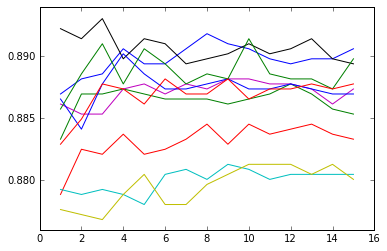

In [8]:
for i in num_votes_accs:
    plt.plot(np.arange(1, 1+len(num_votes_accs[i])), num_votes_accs[i])

In [9]:
num_votes_accs_np = np.zeros((max(RANGE_MODELS), NUM_VOTES), dtype=np.float)
for i in num_votes_accs:
    num_votes_accs_np[i-1] = num_votes_accs[i]
    np.save('log/num_votes_accs.npy', num_votes_accs_np)

# # # # # # # # # # # # # # # # # # # # # # # # #
# MODEL ENSEMBLING 
# # # # # # # # # # # # # # # # # # # # # # # # #

## Calculate probabilities for each test cloud and each model. The output probability array will be the shape of (N, 40, X), where N is the test cloud len and X is the models count to be ensembled.


In [10]:
NUM_MODELS = 10
NUM_VOTES = 12
probabilities = []
true_labels = []
accuracies = []
for x in range(1, NUM_MODELS+1):
    _, acc, _, pred_vals, true_vals = evaluate(model_num=x, num_votes=NUM_VOTES, verbose=False)
    probabilities.append(pred_vals)
    accuracies.append(acc)
    true_labels = np.array(true_vals)
    print ('Model =', x, 'acc = ', acc)
    
probabilities = np.stack(probabilities).transpose(1, 2, 0)
accuracies = np.array(accuracies)

INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_1.ckpt
('Model =', 1, 'acc = ', 0.8893841166936791)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_2.ckpt
('Model =', 2, 'acc = ', 0.8877633711507293)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_3.ckpt
('Model =', 3, 'acc = ', 0.8841166936790924)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from log/model_4.ck

In [15]:
np.save('log/probabilities.npy', probabilities)
np.save('log/true_labels.npy', true_labels)
np.save('log/accuracies.npy', accuracies)

# Models evaluation statistics

In [11]:
print('Mean accuracy =', statistics.mean(accuracies))
indices = {}
for k in range(40):
    indices[k] = [i for i, x in enumerate(true_labels) if x == k]
    
validation_max_res = []
test_res_at_validation_max = []

for _ in range(1000):
    validation_indices = []
    test_indices = []
    for k in indices:
        random.shuffle(indices[k])
        split_idx = int(len(indices[k])/2)
        validation_indices += indices[k][:split_idx]
        test_indices += indices[k][split_idx:]
    validation_indices = sorted(validation_indices)
    test_indices = sorted(test_indices)

    validation_true_labels = true_labels[validation_indices]
    validation_probabilities = probabilities[validation_indices]
    test_true_labels = true_labels[test_indices]
    test_probabilities = probabilities[test_indices]

    validation_predictions = np.argmax(validation_probabilities, axis=1)
    validation_compare = np.equal(validation_predictions, np.expand_dims(validation_true_labels, -1))
    validation_accuracies = np.mean(validation_compare, axis=0)

    test_predictions = np.argmax(test_probabilities, axis=1)
    test_compare = np.equal(test_predictions, np.expand_dims(test_true_labels, -1))
    test_accuracies = np.mean(test_compare, axis=0)

    validation_max_res.append(np.max(validation_accuracies))
    test_res_at_validation_max.append(test_accuracies[np.argmax(validation_accuracies)])
    
mean_valid_max = statistics.mean(validation_max_res)
mean_test_at_valid_max = statistics.mean(test_res_at_validation_max)

print('Mean of validation max results =', mean_valid_max)
print('Mean of test result for validation max =', mean_test_at_valid_max)

('Mean accuracy =', 0.8864667747163695)
('Mean of validation max results =', 0.8923606158833063)
('Mean of test result for validation max =', 0.8862147487844408)


# Agregate the outputs with sum operation

In [12]:
aggregated_probability = np.sum(probabilities, axis=-1)
aggregated_predictions = np.argmax(aggregated_probability, axis=-1)
float(np.sum(aggregated_predictions == true_labels)) / len(true_labels)

0.8938411669367909

# Agregate the outputs with mean operation

In [13]:
aggregated_probability = np.mean(probabilities, axis=-1)
aggregated_predictions = np.argmax(aggregated_probability, axis=-1)
float(np.sum(aggregated_predictions == true_labels)) / len(true_labels)

0.8938411669367909

# Agregate the outputs with mode operation

In [14]:
aggregated_predictions = np.argmax(probabilities, axis=1)
aggregated_predictions =  np.squeeze(stats.mode(aggregated_predictions, axis=1)[0])
float(np.sum(aggregated_predictions == true_labels)) / len(true_labels)

0.8954619124797407